# 청년순이동률 TOP 5

| 지역 |  청년순이동률 |
| -- | -- |
| 전남 무안군 | 4.9 |
| 충남 아산시 | 4.9 |
| 충남 홍성군 | 3.5 |
| 전북 완주군 | 3.5 |
| 경북 안동시 | 2.8 |

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

key = os.getenv("KOSIS_API_KEY")


In [2]:
import pandas as pd
import requests as req

base_url = "https://kosis.kr/openapi/statisticsData.do"

params = {
    "method": "getMeta",
    "type": "ITM",
    "apiKey": key,
    "orgId": "101",
    "tblId": "DT_1YL20642",
    "format": "json",
    "jsonVD": "Y",
}

res = req.get(base_url, params=params)

print(res.status_code)

res_text = res.text

print(res_text)

df = pd.DataFrame(res.json())
df.to_csv("../../data/item_code.csv")

200
[{"OBJ_NM_ENG":"Item code list","ITM_ID":"T001","TBL_ID":"DT_1YL20642","OBJ_NM":"항목","ITM_NM":"청년순이동률","ORG_ID":"101","OBJ_ID":"ITEM"},{"ITM_ID":"00","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"전국","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"ITM_ID":"11","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"서울특별시","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11010","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"종로구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11020","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"중구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11030","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"용산구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11040","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"성동구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11050","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"광진구","

In [3]:
import requests as req

url = "https://kosis.kr/openapi/Param/statisticsParameterData.do"
params = {
    "method": "getList",
    "apiKey": key,
    "orgId": "101",
    "tblId": "DT_1YL20642",
    "itmId": "T001",
    "objL1": "ALL",
    "objL2": "ALL",  # 필수
    "prdSe": "Y",
    "newEstPrdCnt": "3",
    "format": "json",
    "jsonVD": "Y",  # 이거 안넣으면 json 형태로 안옴
}

res = req.get(url, params=params)
print(res.status_code)
print(res.text[:300])


200
[{"C1_OBJ_NM":"행정구역별","C2_NM":"청년순이동률(19~39세)","DT":"0","C2":"11","C1":"00","PRD_SE":"A","UNIT_NM_ENG":"%","ITM_ID":"T001","TBL_ID":"DT_1YL20642","ITM_NM":"청년순이동률","TBL_NM":"청년순이동률(시도/시/군/구)","PRD_DE":"2022","LST_CHN_DE":"2024-10-08","C1_NM":"전국","UNIT_NM":"%","ORG_ID":"101","C2_OBJ_NM":"청년순이동률 지표"}


In [4]:
import pandas as pd

df = pd.DataFrame(res.json())
df.head()

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4428 entries, 0 to 4427
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   C1_OBJ_NM    4428 non-null   object
 1   C2_NM        4428 non-null   object
 2   DT           4428 non-null   object
 3   C2           4428 non-null   object
 4   C1           4428 non-null   object
 5   PRD_SE       4428 non-null   object
 6   UNIT_NM_ENG  4428 non-null   object
 7   ITM_ID       4428 non-null   object
 8   TBL_ID       4428 non-null   object
 9   ITM_NM       4428 non-null   object
 10  TBL_NM       4428 non-null   object
 11  PRD_DE       4428 non-null   object
 12  LST_CHN_DE   4428 non-null   object
 13  C1_NM        4428 non-null   object
 14  UNIT_NM      4428 non-null   object
 15  ORG_ID       4428 non-null   object
 16  C2_OBJ_NM    4428 non-null   object
dtypes: object(17)
memory usage: 588.2+ KB


,C1_OBJ_NM,C2_NM,DT,C2,C1,PRD_SE,UNIT_NM_ENG,ITM_ID,TBL_ID,ITM_NM,TBL_NM,PRD_DE,LST_CHN_DE,C1_NM,UNIT_NM,ORG_ID,C2_OBJ_NM
count,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
unique,1,6,2803,6,247,1,2,1,1,1,1,3,2,224,2,1,1
top,행정구역별,청년순이동률(19~39세),0,11,00,A,In person,T001,DT_1YL20642,청년순이동률,청년순이동률(시도/시/군/구),2022,2024-10-08,중구,명,101,청년순이동률 지표
freq,4428,738,36,738,18,4428,2952,4428,4428,4428,4428,1476,2952,108,2952,4428,4428


In [5]:
# 1. 데이터 타입 정리
df["DT"] = pd.to_numeric(df["DT"], errors="coerce")
df["PRD_DE"] = df["PRD_DE"].astype(str)

# 2. 제외 지역
exclude_sido = {"11", "23", "31", "21", "22", "24", "25", "26"}  # 수도권+광역시

# 3. 타입 변환
df = df.copy()
df["C1"] = df["C1"].astype(str)

# 4. 시도코드(앞 2자리) 생성
df["SIDO"] = df["C1"].str[:2]

# 5. 청년순이동률만
df = df[df["C2"] == "11"].copy()

# 6. 수도권 + 광역시 제외 (앞2자리 기준)
df = df[~df["SIDO"].isin(exclude_sido)].copy()

# 7. 최신연도 TOP5
latest_year = df["PRD_DE"].astype(str).max()

top_5 = (
    df[df["PRD_DE"].astype(str) == latest_year][["C1", "C1_NM", "SIDO", "DT"]]
    .assign(DT=lambda x: pd.to_numeric(x["DT"], errors="coerce"))
    .dropna(subset=["DT"])
    .rename(columns={"C1_NM": "지역", "DT": "청년순이동률", "SIDO": "시도"})
    .sort_values("청년순이동률", ascending=False)
    .head(5)
)

print(top_5[["C1", "지역", "청년순이동률"]])

         C1   지역  청년순이동률
3488  36620  무안군     4.9
2714  34040  아산시     4.9
2876  34560  홍성군     3.5
3056  35510  완주군     3.5
3686  37040  안동시     2.8


In [6]:
sido_map = {
    "11": "서울",
    "21": "부산",
    "22": "대구",
    "23": "인천",
    "24": "광주",
    "25": "대전",
    "26": "울산",
    "29": "세종",
    "31": "경기",
    "32": "강원",
    "33": "충북",
    "34": "충남",
    "35": "전북",
    "36": "전남",
    "37": "경북",
    "38": "경남",
    "39": "제주",
}

top_5["시도"] = df["C1"].astype(str).str[:2].map(sido_map)

top_5

,C1,지역,시도,청년순이동률
3488,36620,무안군,전남,4.9
2714,34040,아산시,충남,4.9
2876,34560,홍성군,충남,3.5
3056,35510,완주군,전북,3.5
3686,37040,안동시,경북,2.8


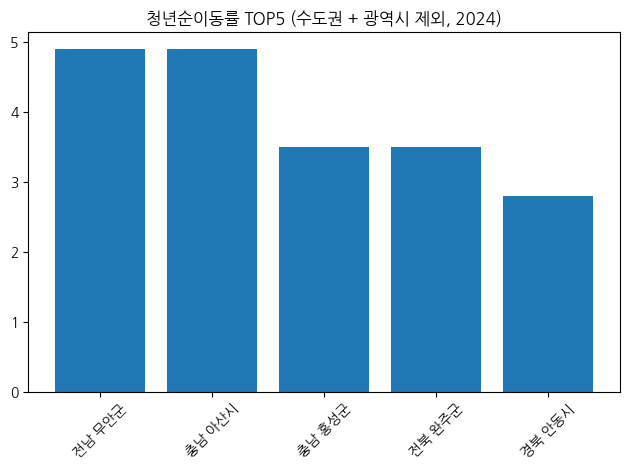

In [7]:
import koreanize_matplotlib  # noqa: F401
import matplotlib.pyplot as plt

top_5["시도명"] = top_5["시도"].map(sido_map).fillna(top_5["시도"])
top_5["라벨"] = top_5["시도명"] + " " + top_5["지역"]

plt.figure()
plt.bar(top_5["라벨"], top_5["청년순이동률"])
plt.title(f"청년순이동률 TOP5 (수도권 + 광역시 제외, {latest_year})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
